March Madness Pre-2025 Results
==========================

This notebook will explore predictions for the 2024 March Madness tournament and before, based on Massey rankings and tournament seeding. The purpose is to create a model for predicting tournament performance that can be applied to the 2025 teams.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn.metrics as ms
import sklearn.preprocessing as pre

from scipy import interpolate

### CONSTANTS ###

DATA_DIR = '../data/kaggle/'
SYSTEM_NAME = "MB"
YEARS = [ 2024 ]

### FUNCTIONS ###

def extract_seed_value(seed_str):
    try:
        return int(seed_str[1:])
    except:
        np.nan

def get_cross_game_id(row):
    season = int(row["Season"])
    team_x1 = int(row["TeamID_X1"])
    team_x2 = int(row["TeamID_X2"])

    return f"{season}_{team_x1}_{team_x2}"

def get_tournament_game_id(row):
    season = int(row["Season"])
    team_w = int(row["WTeamID"])
    team_l = int(row["LTeamID"])

    if team_w >= team_l:
        return f"{season}_{team_l}_{team_w}"
    else:
        return f"{season}_{team_w}_{team_l}"

def extract_game_info(id_str):

    # Extract year and team_ids
    parts = id_str.split('_')
    year = int(parts[0])
    teamID1 = int(parts[1])
    teamID2 = int(parts[2])
    return year, teamID1, teamID2

def does_team1_win(row):

    y, team1, team2 = extract_game_info(row["GameID"])
    if row["WTeamID"] == team1:
        return 1
    else:
        return 0

# Load Team Data and Rankings

Start by loading the seed data for the season(s) listed in the YEARS array, expected to be 68 teams. For now, this notebook is focused on the men's results, to keep the datasets small for initial exploration. Once the model is created, it should be relatively trivial to add results for the women's tournament.

In [20]:
df_ = pd.read_csv( DATA_DIR + "MNCAATourneySeeds.csv" )
df_seeds = df_[ df_["Season"].isin( YEARS ) ]
df_seeds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 2490 to 2557
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Season  68 non-null     int64 
 1   Seed    68 non-null     object
 2   TeamID  68 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ KB


Next, load the Massey rankings for the same set of seasons. For initial exploration, this notebook is only concerned with the most recent results of a single system ("Massey BCS") before the tournament. Future exploration could include other rankings.

In [21]:
df_ = pd.read_csv( DATA_DIR + "MMasseyOrdinals.csv" )

last_ranking_day = {}
df_massey = pd.DataFrame()

for y in YEARS:

    df_year = df_[ df_[ "Season" ] == y ].copy()
    last_ranking_day = df_year[ "RankingDayNum" ].unique()[-1]

    df_sub = df_year[ ( df_year[ "RankingDayNum" ] == last_ranking_day ) & \
                      ( df_year[ "SystemName" ] == SYSTEM_NAME ) ].copy()

    print(f"Last ranking day of {y} season is {last_ranking_day}")

    if df_massey.empty:
        df_massey = df_sub
    else:
        df_massey = pd.concat( [df_massey, df_sub] )

Last ranking day of 2024 season is 133


In [22]:
df_massey.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 5254396 to 5254757
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Season         362 non-null    int64 
 1   RankingDayNum  362 non-null    int64 
 2   SystemName     362 non-null    object
 3   TeamID         362 non-null    int64 
 4   OrdinalRank    362 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 17.0+ KB


Drop the season data for both dataframes, then merge the two so that anything that doesn't have a "Seed" value is marked as n/a.

In [23]:
df_teams = df_massey.merge( df_seeds, on=['TeamID', 'Season'], how='left' )
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Season         362 non-null    int64 
 1   RankingDayNum  362 non-null    int64 
 2   SystemName     362 non-null    object
 3   TeamID         362 non-null    int64 
 4   OrdinalRank    362 non-null    int64 
 5   Seed           68 non-null     object
dtypes: int64(4), object(2)
memory usage: 17.1+ KB


Merge team names into the dataframe, for ease of reading.

In [24]:
df_teams_details = pd.read_csv( DATA_DIR + "MTeams.csv" )

df_teams = df_teams.merge( df_teams_details, on=['TeamID' ], how='left' )
df_teams['SeedValue'] = df_teams['Seed'].apply(extract_seed_value)

df_teams.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank,Seed,TeamName,FirstD1Season,LastD1Season,SeedValue
0,2024,133,MB,1101,196,NaN,Abilene Chr,2014,2025,NaN
1,2024,133,MB,1102,270,NaN,Air Force,1985,2025,NaN
2,2024,133,MB,1103,109,Y14,Akron,1985,2025,14.0
3,2024,133,MB,1104,17,X04,Alabama,1985,2025,4.0
4,2024,133,MB,1105,326,NaN,Alabama A&M,2000,2025,NaN


# Missing Seed Values

The seed value can act as important piece of information, and it's included ONLY for teams that made the playoffs. Given the format of the 2025 March Madness competetetion, the model will function better if the missing seed values can be filled in. To that end, this notebook will use Massey system rankings to impute seed values for groups that didn't make it into the tournament.

# Create Hypothetical Matchups

This section will turn the list of 362 teams for the men's season into 65K hypothetical matchups, which we can then use to predict the overall outcomes of the 2024 tournament.

In [25]:
df_teams_sub = df_teams[[ "TeamID", "TeamName", "OrdinalRank", "Seed", "SeedValue", "Season" ]]
cross_teams = pd.merge( df_teams_sub, df_teams_sub, how="cross", suffixes=["_X1", "_X2"] )

cross_teams.drop( "Season_X2", axis=1, inplace=True )
cross_teams.rename( columns={ "Season_X1": "Season" }, inplace=True )

cross_teams.shape

(131044, 11)

Per the expected submissions data, any rows where TeamID_X1 >= TeamID_X2 are dropped. For the 2025 season, this _should_ provide a total of 131407 rows (men's and women's teams) and a header in the submissions dataset.

In [26]:
cross_teams = cross_teams.drop( cross_teams[ cross_teams["TeamID_X1"] >= cross_teams["TeamID_X2"] ].index )
cross_teams.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65341 entries, 1 to 130681
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TeamID_X1       65341 non-null  int64  
 1   TeamName_X1     65341 non-null  object 
 2   OrdinalRank_X1  65341 non-null  int64  
 3   Seed_X1         13068 non-null  object 
 4   SeedValue_X1    11361 non-null  float64
 5   Season          65341 non-null  int64  
 6   TeamID_X2       65341 non-null  int64  
 7   TeamName_X2     65341 non-null  object 
 8   OrdinalRank_X2  65341 non-null  int64  
 9   Seed_X2         11480 non-null  object 
 10  SeedValue_X2    10299 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 6.0+ MB


Run final processing on the cross-team merge, including calculating diffs in rankings between teams, and setting the game id.

In [27]:
cross_teams["RankDiff"] = cross_teams["OrdinalRank_X1"] - cross_teams["OrdinalRank_X2"]
cross_teams["GameID"] = cross_teams.apply( get_cross_game_id, axis=1 )

Show the hypothetical matchups for a team that usually gets ranked. This notebook assumes "TeamName_X2" will only have teams that come after Gonzaga in the alphabet.

In [28]:
df_gonzaga = cross_teams[ cross_teams["TeamName_X1"] == "Gonzaga" ].copy()
df_gonzaga[["GameID", "TeamName_X1", "TeamName_X2", "RankDiff"]].head(5).style.hide(axis="index")

GameID,TeamName_X1,TeamName_X2,RankDiff
2024_1211_1212,Gonzaga,Grambling,-217
2024_1211_1213,Gonzaga,Grand Canyon,-12
2024_1211_1214,Gonzaga,Hampton,-311
2024_1211_1217,Gonzaga,Harvard,-169
2024_1211_1218,Gonzaga,Hawaii,-149


# Train the Model

# Load Tournament Results

In [29]:
df_ = pd.read_csv( DATA_DIR + "MNCAATourneyCompactResults.csv" )
df_tourney = df_[ df_["Season"].isin( YEARS ) ].copy()

df_tourney["GameID"] = df_tourney.apply( get_tournament_game_id, axis=1 )
df_tourney["Team1Win"] = df_tourney.apply( does_team1_win, axis=1 )

df_tourney.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 2451 to 2517
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Season    67 non-null     int64 
 1   DayNum    67 non-null     int64 
 2   WTeamID   67 non-null     int64 
 3   WScore    67 non-null     int64 
 4   LTeamID   67 non-null     int64 
 5   LScore    67 non-null     int64 
 6   WLoc      67 non-null     object
 7   NumOT     67 non-null     int64 
 8   GameID    67 non-null     object
 9   Team1Win  67 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 5.8+ KB


# Merge Tournament Results with Predictions

To help better analyze the data, we will be cleaning and pre-processing the 2024 results, as well as incorporating seed values and Massey rankings.

In [30]:
df_merged = df_tourney.merge(cross_teams[[ "GameID", "RankDiff" ]], how="left", on="GameID" )
#df_merged["PredictedWin"] = df_merged["RankDiff"].apply( lambda v: 1 if v < 0 else 0 )

In [31]:
minmax = pre.MinMaxScaler()
series_transformed = minmax.fit_transform(df_merged[["RankDiff"]])
df_merged["NormalizedRankDiff"] = 1 - series_transformed[:,0].round(4)

In [32]:
df_merged.shape

(67, 12)

In [33]:
df_merged[["NormalizedRankDiff"]].describe()

,NormalizedRankDiff
count,67.000000
mean,0.486491
std,0.141375
min,0.000000
25%,0.425600
50%,0.470800
75%,0.538600
max,1.000000


In [34]:
df_merged.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,GameID,Team1Win,RankDiff,NormalizedRankDiff
0,2024,134,1161,67,1438,42,N,0,2024_1161_1438,1,-1,0.4482
1,2024,134,1447,71,1224,68,N,0,2024_1224_1447,0,-26,0.4953
2,2024,135,1160,60,1129,53,N,0,2024_1129_1160,0,21,0.4068
3,2024,135,1212,88,1286,81,N,0,2024_1212_1286,1,1,0.4444
4,2024,136,1112,85,1253,65,N,0,2024_1112_1253,1,-130,0.6911
5,2024,136,1166,77,1103,60,N,0,2024_1103_1166,0,95,0.2674
6,2024,136,1173,63,1305,60,N,0,2024_1173_1305,1,11,0.4256
7,2024,136,1182,71,1140,67,N,0,2024_1140_1182,0,-52,0.5443
8,2024,136,1211,86,1270,65,N,0,2024_1211_1270,1,-41,0.5235
9,2024,136,1228,85,1287,69,N,0,2024_1228_1287,1,-121,0.6742


# Check Model Performance

In [35]:
y_preds = df_merged["NormalizedRankDiff"]
y = df_merged["Team1Win"]

fpr, tpr, thresh = ms.roc_curve(y, y_preds)
roc_auc = ms.auc(fpr, tpr)

# Calculate the geometric mean
gmeans = np.sqrt(tpr * (1 - fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
threshold = thresh[index]

tpr_intrp = interpolate.interp1d(thresh, tpr)
fpr_intrp = interpolate.interp1d(thresh, fpr)

print(f"AUC {round(roc_auc,3)}")
print(f"Optimal threshold {round(threshold,3)} at " \
      f"tpr: {np.round(tpr_intrp(threshold),3)}, " \
      f"fpr: {np.round(fpr_intrp(threshold),3)}")

AUC 0.714
Optimal threshold 0.444 at tpr: 0.744, fpr: 0.375


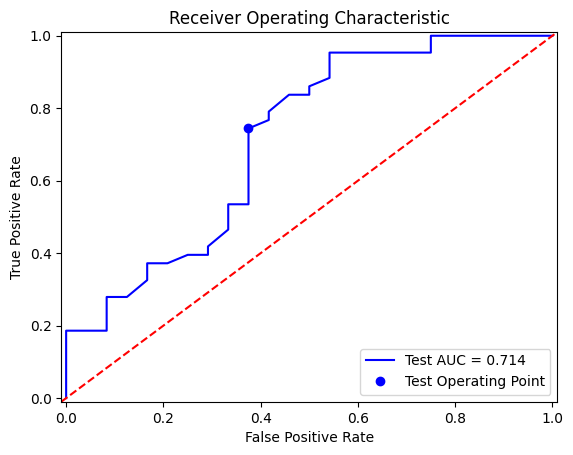

In [36]:
min_limit = -0.01
max_limit = 1.01

operating_point_fpr = fpr_intrp(threshold)
operating_point_tpr = tpr_intrp(threshold)

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.3f' % roc_auc)
plt.plot(operating_point_fpr, operating_point_tpr, 'bo', label=f'Test Operating Point')

plt.plot([min_limit, max_limit], [min_limit, max_limit],'r--')

plt.xlim([min_limit, max_limit])
plt.ylim([min_limit, max_limit])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()